In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/covid analysis

/content/drive/MyDrive/covid analysis


In [3]:
!pip install cleantext
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 16.2 MB/s 
     |████████████████████████████████| 6.6 MB 39.0 MB/s 
     |████████████████████████████████| 120 kB 67.8 MB/s 


In [4]:
import numpy as np
import pandas as pd
import os
import json
import os
import pickle
import re
import cleantext
import random
from transformers import GPT2Tokenizer
import string

# 챗봇 훈련에 사용할 최종 데이터 불러오기!

In [5]:
from glob import glob
for filename in glob('*.csv'):
  print(filename)

final_master_dataset.csv
All-2479-Answers-retrieved-from-MedQuAD.csv
counselchat-data.csv
contexted_train.csv
topic_label.csv
ts_label.csv
ts_label2.csv
topic_label2.csv
covidQA_Final.csv
medQA.csv
chatbot_finalData.csv


* covidQA

In [6]:
covidQA = pd.read_csv('covidQA_Final.csv', encoding='cp949')
covidQA.drop(columns=["Source", "Unnamed: 3", "Unnamed: 4", "Unnamed: 5", "Unnamed: 6", "Unnamed: 7", "Unnamed: 8", "Unnamed: 9", "Unnamed: 10"], inplace=True)
print(covidQA.shape)
print(covidQA.head())

(486, 2)
                                            Question  \
0                                   What is COVID-19   
1                  What are the symptoms of COVID-19   
2                           How does COVID-19 spread   
3  Can the virus that causes COVID-19 be transmit...   
4  Can CoVID-19 be caught from a person who has n...   

                                              Answer  
0  COVID-19 is the infectious disease caused by t...  
1  The most common symptoms of COVID-19 are fever...  
2  People can catch COVID-19 from others who have...  
3  Studies to date suggest that the virus that ca...  
4  The risk of catching COVID-19 from someone wit...  


* MedQuAD

In [10]:
###Summary 수정 전 버전 파일
medQA = pd.read_csv('All-2479-Answers-retrieved-from-MedQuAD.csv')
medQA.drop(columns = ['AnswerID'], inplace = True)
medQA.head()

,Answer
0,Question: What is (are) Polycystic ovary syndr...
1,Question: What causes Polycystic ovary syndrom...
2,Question: What causes Noonan syndrome ?\nURL: ...
3,Question: What are the complications of Noonan...
4,Question: How to prevent Noonan syndrome ?\nUR...


In [22]:
medQA_split = medQA.Answer.str.split('\n', expand=True)
medQA_split.to_csv('medQA.csv', index = None)

In [7]:
###Summary 수정 후 파일
medQA = pd.read_csv('medQA.csv', encoding = 'cp949')
medQA_ex = medQA[['0', '2']]
medQA_ex.head()

,0,2
0,Question: What is (are) Polycystic ovary syndr...,Answer: Polycystic ovary syndrome is a conditi...
1,Question: What causes Polycystic ovary syndrom...,Answer: PCOS is linked to changes in hormone l...
2,Question: What causes Noonan syndrome ?,Answer: Noonan syndrome is linked to defects i...
3,Question: What are the complications of Noonan...,Answer: - Buildup of fluid in tissues of body ...
4,Question: How to prevent Noonan syndrome ?,Answer: Couples with a family history of Noona...


In [8]:
medQA_ex['0'].replace("Question: ", "", regex = True, inplace = True)
medQA_ex['2'].replace("Answer: ", "", regex = True, inplace = True)
medQA_ex.columns = ['Question', 'Answer']
medQA_ex.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,Question,Answer
0,What is (are) Polycystic ovary syndrome ? (Als...,Polycystic ovary syndrome is a condition in wh...
1,What causes Polycystic ovary syndrome ? (Also ...,PCOS is linked to changes in hormone levels th...
2,What causes Noonan syndrome ?,Noonan syndrome is linked to defects in severa...
3,What are the complications of Noonan syndrome ?,- Buildup of fluid in tissues of body (lymphed...
4,How to prevent Noonan syndrome ?,Couples with a family history of Noonan syndro...


* Validate + Test

In [9]:
# 출처 
DATA_DIR = 'data/english'
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

def process_gpt2_bpe(sent):
    gpt2_tokens = tokenizer.tokenize(sent)

    processed_tokens = [gpt2_tokens[0]]
    for token in gpt2_tokens[1:]:
        if any([s in string.ascii_letters for s in token]):
            if not token.startswith('Ġ'):
                if processed_tokens[-1][-1] not in string.punctuation:
                    processed_tokens[-1] += '@@'
            else:
                token = token[1:]
        processed_tokens.append(token)
    return ' '.join(processed_tokens)


def print_fairseq_format():
    for split in ['train', 'dev', 'test']:
        dialogues = pickle.load(open(f'{DATA_DIR}/{split}.pickle', 'rb'))

        src_file = open(f'{DATA_DIR}/{split}.chat_history', 'w')
        tgt_file = open(f'{DATA_DIR}/{split}.response', 'w')
        for dialogue in dialogues:
            src = 'description: ' + dialogue['description'] + ' ; '
            for i, utterance in enumerate(dialogue['utterances']):
                if i % 2 == 0:
                    src += 'patient: ' + utterance + ' ; '
                else:
                    print(src, file=src_file)
                    print(utterance, file=tgt_file)
                    src += 'doctor: ' + utterance + ' ; '


os.makedirs(DATA_DIR, exist_ok=True)
if not os.path.exists(os.path.join(DATA_DIR, 'COVID-Dialogue-Dataset-English.txt')):
    os.system(f'wget -P {DATA_DIR} https://raw.githubusercontent.com/UCSD'
              f'-AI4H/COVID-Dialogue/master/COVID-Dialogue-Dataset'
              f'-English.txt')

dialogues_texts_dirty = open(os.path.join(DATA_DIR, 'COVID-Dialogue-Dataset-English.txt')).read().split('id=')

dialogues = []
for text in dialogues_texts_dirty:
    text = text[text.find('Description'):].strip()

    description = text[len('Description\n'):text.find('\nDialogue')]
    #description = cleantext.clean(description, extra_spaces=True, lowercase=True)

    text = text[text.find('\nPatient:'):]
    utterances, last_person, valid = [], 'None', True
    for x in re.finditer('Doctor:|Patient:', text):
        if x.group() == last_person:
            valid = False
            break
        else:
            last_person = x.group()

        utterance = text[x.end():].split('Patient:')[0].split('Doctor:')[0]
        utterances.append(cleantext.clean(utterance, extra_spaces=True, lowercase=True))

    if valid and utterances:
        dialogues.append({
            'description': description,
            'utterances': utterances
        })

print('#dialogs:', len(dialogues))

random.seed(11111)
random.shuffle(dialogues)

train_size = int(0.8 * len(dialogues))
dev_size = int(0.1 * len(dialogues))

pickle.dump(dialogues[:train_size],
            open(f'{DATA_DIR}/train.pickle', 'wb'))
pickle.dump(dialogues[train_size:train_size + dev_size],
            open(f'{DATA_DIR}/dev.pickle', 'wb'))
pickle.dump(dialogues[train_size + dev_size:],
            open(f'{DATA_DIR}/test.pickle', 'wb'))

print_fairseq_format()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#dialogs: 603


In [10]:
import json
'''
f_train = open("/content/drive/MyDrive/covid analysis/train_data.json")
train_data = json.load(f_train)
f_train.close()
print(len(train_data))
'''

f_validate = open("/content/drive/MyDrive/covid analysis/validate_data.json")
validate_data = json.load(f_validate)
f_validate.close()
print(len(validate_data))

f_test = open("/content/drive/MyDrive/covid analysis/test_data.json")
test_data = json.load(f_test)
f_test.close()
print(len(test_data))

60
61


In [11]:
vt = []
for i in range(len(validate_data)):
  row = []
  row.append(validate_data[i][1])
  row.append(validate_data[i][0])
  vt.append(row)  

for i in range(len(test_data)):
  row = []
  row.append(test_data[i][1])
  row.append(test_data[i][0])
  vt.append(row)  

columns = ['Question', 'Answer'] 
columns = columns + ['context/'+str(i) for i in range(0)]
columns

['Question', 'Answer']

In [12]:
print(len(vt))
trn_df = pd.DataFrame(vt, columns= ['Question', 'Answer'])
trn_df

121


,Question,Answer
0,Corona-virus. At 33 you may not need testing. ...,I have a constant cough and my chest has now b...
1,Less likely. Recommended to stay 6 feet apart....,If someone has carona virus and iam passing by...
2,"Test Please stay at home, rest, drink fluids...",I am concerned that I’m showing symptoms of co...
3,Death. At your age the risk of death is the fo...,What are my chances of becoming seriously ill ...
4,Unknown but low Based on current data it is ...,Nervous about coronavirus. I am 26 years old a...
...,...,...
116,"Coronavirus, COVID-19 has high affinity to t...","If I get coronavirus, are there ways to avoid ..."
117,COVID These are HealthTap guidelines:https:/...,I was on a plane on March 8th have been home e...
118,Covid-19 unlikely. The usual infections in y...,"My son has a fever, I am concerned due to the ..."
119,Symptoms vary. Some may have no symptoms at ...,Can coronavirus symptoms be mild for some peop...


In [49]:
df = pd.concat([covidQA, medQA_ex, trn_df], ignore_index = True)
df.head()

,Question,Answer
0,What is COVID-19,COVID-19 is the infectious disease caused by t...
1,What are the symptoms of COVID-19,The most common symptoms of COVID-19 are fever...
2,How does COVID-19 spread,People can catch COVID-19 from others who have...
3,Can the virus that causes COVID-19 be transmit...,Studies to date suggest that the virus that ca...
4,Can CoVID-19 be caught from a person who has n...,The risk of catching COVID-19 from someone wit...


In [14]:
df.shape

(3086, 2)

In [39]:
df.to_csv('chatbot_finalData.csv', index = None)

# Topic Label 매기기 

In [59]:
main_df = pd.DataFrame(df, columns = ['text', 'index'])
main_df['text'] = df['Question'] + " + " + df["Answer"]
main_df['index'] = df.index.values
main_df['Question'] = df['Question']
main_df['Answer'] = df['Answer']
main_df.head()

,text,index,Question,Answer
0,What is COVID-19 + COVID-19 is the infectious ...,0,What is COVID-19,COVID-19 is the infectious disease caused by t...
1,What are the symptoms of COVID-19 + The most c...,1,What are the symptoms of COVID-19,The most common symptoms of COVID-19 are fever...
2,How does COVID-19 spread + People can catch CO...,2,How does COVID-19 spread,People can catch COVID-19 from others who have...
3,Can the virus that causes COVID-19 be transmit...,3,Can the virus that causes COVID-19 be transmit...,Studies to date suggest that the virus that ca...
4,Can CoVID-19 be caught from a person who has n...,4,Can CoVID-19 be caught from a person who has n...,The risk of catching COVID-19 from someone wit...


In [16]:
from tqdm import tqdm
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import pkg_resources

import datetime
import time
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [17]:
from collections import Counter
from sklearn.metrics import silhouette_score
!pip uninstall umap
!pip install umap-learn
!pip install symspellpy
!pip install language_detector
!pip install stop_words
import umap.umap_ as umap
import pkg_resources
from symspellpy import SymSpell, Verbosity
from language_detector import detect_language
from gensim.models.coherencemodel import CoherenceModel
from stop_words import get_stop_words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 5.9 MB/s 
     |████████████████████████████████| 1.1 MB 57.8 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=43404436f383d19fe819add47a334f7daa775ba50357c053f11b40aea4b547eb
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=a7a10cb995d157c03a2842cbe7c398bea24812b7d01f56ab521c77510b1a7905
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.6 MB 28.9 MB/s 
     |████████████████████████████████| 125 kB 68.3 MB/s

In [18]:
sym_spell = SymSpell(max_dictionary_edit_distance=3, prefix_length = 7)
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
if sym_spell.word_count:
  pass
else :
  sym_spell.load_dictionary(dictionary_path, term_index = 0, count_index = 1)

# some basic normalization
def f_base(s):
    """
    :param s: string to be processed
    :return: processed string: see comments in the source code for more info
    """
    # normalization 1: xxxThis is a --> xxx. This is a (missing delimiter)
    s = re.sub(r'([a-z])([A-Z])', r'\1\. \2', s)  # before lower case
    # normalization 2: lower case
    s = s.lower()
    # normalization 3: "&gt", "&lt"
    s = re.sub(r'&gt|&lt', ' ', s)
    # normalization 4: letter repetition (if more than 2)
    s = re.sub(r'([a-z])\1{2,}', r'\1', s)
    # normalization 5: non-word repetition (if more than 1)
    s = re.sub(r'([\W+])\1{1,}', r'\1', s)
    # normalization 6: string * as delimiter
    s = re.sub(r'\*|\W\*|\*\W', '. ', s)
    # normalization 7: stuff in parenthesis, assumed to be less informal
    s = re.sub(r'\(.*?\)', '. ', s)
    # normalization 8: xxx[?!]. -- > xxx.
    s = re.sub(r'\W+?\.', '.', s)
    # normalization 9: [.?!] --> [.?!] xxx
    s = re.sub(r'(\.|\?|!)(\w)', r'\1 \2', s)
    # normalization 10: ' ing ', noise text
    s = re.sub(r' ing ', ' ', s)
    # normalization 11: noise text
    s = re.sub(r'product received for free[.| ]', ' ', s)
    # normalization 12: phrase repetition
    s = re.sub(r'(.{2,}?)\1{1,}', r'\1', s)

    return s.strip()

def f_lan(s):
  return detect_language(s) in {'English'}

###############################
#### word level preprocess ####
###############################

# filtering out punctuations and numbers
def f_punct(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with punct and number filter out
    """
    return [word for word in w_list if word.isalpha()]


# selecting nouns
def f_noun(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with only nouns selected
    """
    return [word for (word, pos) in nltk.pos_tag(w_list) if pos[:2] == 'NN']


# typo correction
def f_typo(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with typo fixed by symspell. words with no match up will be dropped
    """
    w_list_fixed = []
    for word in w_list:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=3)
        if suggestions:
            w_list_fixed.append(suggestions[0].term)
        else:
            pass
            # do word segmentation, deprecated for inefficiency
            # w_seg = sym_spell.word_segmentation(phrase=word)
            # w_list_fixed.extend(w_seg.corrected_string.split())
    return w_list_fixed


# stemming if doing word-wise
p_stemmer = PorterStemmer()


def f_stem(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with stemming
    """
    return [p_stemmer.stem(word) for word in w_list]


# filtering out stop words
# create English stop words list

stop_words = (list(
    set(get_stop_words('en'))
    |set(get_stop_words('es'))
    |set(get_stop_words('de'))
    |set(get_stop_words('it'))
    |set(get_stop_words('ca'))
    #|set(get_stop_words('cy'))
    |set(get_stop_words('pt'))
    #|set(get_stop_words('tl'))
    |set(get_stop_words('pl'))
    #|set(get_stop_words('et'))
    |set(get_stop_words('da'))
    |set(get_stop_words('ru'))
    #|set(get_stop_words('so'))
    |set(get_stop_words('sv'))
    |set(get_stop_words('sk'))
    #|set(get_stop_words('cs'))
    |set(get_stop_words('nl'))
    #|set(get_stop_words('sl'))
    #|set(get_stop_words('no'))
    #|set(get_stop_words('zh-cn'))
))


def f_stopw(w_list):
    """
    filtering out stop words
    """
    return [word for word in w_list if word not in stop_words]


def preprocess_sent(rw):
    """
    Get sentence level preprocessed data from raw review texts
    :param rw: review to be processed
    :return: sentence level pre-processed review
    """
    s = f_base(rw)
    if not f_lan(s):
        return None
    return s


def preprocess_word(s):
    """
    Get word level preprocessed data from preprocessed sentences
    including: remove punctuation, select noun, fix typo, stem, stop_words
    :param s: sentence to be processed
    :return: word level pre-processed review
    """
    if not s:
        return None
    w_list = word_tokenize(s)
    w_list = f_punct(w_list)
    w_list = f_noun(w_list)
    w_list = f_typo(w_list)
    w_list = f_stem(w_list)
    w_list = f_stopw(w_list)

    return w_list

In [19]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [20]:
def get_topic_words(token_lists, labels, k=None):
    """
    get top words within each topic from clustering results
    """
    if k is None:
        k = len(np.unique(labels))

    topics = ['' for _ in range(k)]

    for i, c in enumerate(token_lists):
        topics[labels[i]] += (' ' + ' '.join(c))
        if i%100000 == 0 :
          print(i)

    word_counts = list(map(lambda x: Counter(x.split()).items(), topics))
    # get sorted word counts
    word_counts = list(map(lambda x: sorted(x, key=lambda x: x[1], reverse=True), word_counts))
    # get topics
    topics = list(map(lambda x: list(map(lambda x: x[0], x[:10])), word_counts))

    return topics

def get_coherence(model, token_lists, measure='c_v'):
    """
    Get model coherence from gensim.models.coherencemodel
    :param model: Topic_Model object
    :param token_lists: token lists of docs
    :param topics: topics as top words
    :param measure: coherence metrics
    :return: coherence score
    """
    if model.method == 'LDA':
        cm = CoherenceModel(model=model.ldamodel, texts=token_lists, 
                            corpus=model.corpus, dictionary=model.dictionary, coherence=measure)
    else:
        print("Start get topic words")
        topics = get_topic_words(token_lists, model.cluster_model.labels_)
        print("Done! and start get coherence")
        cm = CoherenceModel(topics=topics, texts=token_lists, 
                            corpus=model.corpus, dictionary=model.dictionary, coherence=measure)
        print("Get coherence done!")
    return cm.get_coherence()

def get_silhouette(model):
    """
    Get silhouette score from model
    :param model: Topic_Model object
    :return: silhouette score
    """
    if model.method == 'LDA':
       return
    else :
      lbs = model.cluster_model.labels_
      vec = model.vec[model.method]
    return silhouette_score(vec, lbs)

def plot_proj(embedding, lbs):
    """
    Plot UMAP embeddings
    :param embedding: UMAP (or other) embeddings
    :param lbs: labels
    """
    n = len(embedding)
    counter = Counter(lbs)
    for i in range(len(np.unique(lbs))):
        plt.plot(embedding[:, 0][lbs == i], embedding[:, 1][lbs == i], '.', alpha=0.5,
                 label='cluster {}: {:.2f}%'.format(i, counter[i] / n * 100))
    #plt.legend(loc = 'best')
    plt.grid(color ='grey', linestyle='-',linewidth = 0.25)
    plt.show()


def visualize(model):
    """
    Visualize the result for the topic model by 2D embedding (UMAP)
    :param model: Topic_Model object
    """
    if model.method == 'LDA':
        return
    reducer = umap.UMAP()
    print('Calculating UMAP projection ...')
    vec_umap = reducer.fit_transform(model.vec[model.method])
    print('Calculating UMAP projection. Done!')
    plot_proj(vec_umap, model.cluster_model.labels_)
    label = model.cluster_model.labels_
    print(label)
    print(len(label))
    dr = '/content/drive/MyDrive/covid analysis/lda+bert result/{}/{}'.format(model.method, model.id)
    if not os.path.exists(dr):
        os.makedirs(dr)
    plt.savefig('/2D_vis')
    return label

def get_wordcloud(model, token_lists, topic):
    """
    Get word cloud of each topic from fitted model
    :param model: Topic_Model object
    :param sentences: preprocessed sentences from docs
    """
    if model.method == 'LDA':
        return
    print('Getting wordcloud for topic {} ...'.format(topic))
    lbs = model.cluster_model.labels_
    label = np.array(lbs)
    print(len(label))
    main_df['topic_label'] = label

    # main_df에 topic 컬럼 추가해서 숫자 집어넣기!

    tokens = ' '.join([' '.join(_) for _ in np.array(token_lists)[lbs == topic]])
    build = np.array(token_lists)
    print(len(build))
    #print(np.array(token_lists)[lbs == topic])

    wordcloud = WordCloud(width=800, height=560,
                          background_color='white', collocations=False,
                          min_font_size=10).generate(tokens)

    # plot the WordCloud image
    plt.figure(figsize=(8, 5.6), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    dr = '/content/drive/MyDrive/covid analysis/lda+bert result/{}/{}'.format(model.method, model.id)
    if not os.path.exists(dr):
        os.makedirs(dr)
    plt.savefig('/content/drive/MyDrive/covid analysis/lda+bert result' + '/Topic' + str(topic) + '_wordcloud')
    print('Getting wordcloud for topic {}. Done!'.format(topic))

In [21]:
import keras
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [22]:
class Autoencoder:
    """
    Autoencoder for learning latent space representation
    architecture simplified for only one hidden layer
    """

    def __init__(self, latent_dim=32, activation='relu', epochs=200, batch_size=128):
        self.latent_dim = latent_dim
        self.activation = activation
        self.epochs = epochs
        self.batch_size = batch_size
        self.autoencoder = None
        self.encoder = None
        self.decoder = None
        self.his = None

    def _compile(self, input_dim):
        """
        compile the computational graph
        """
        input_vec = Input(shape=(input_dim,))
        encoded = Dense(self.latent_dim, activation=self.activation)(input_vec)
        decoded = Dense(input_dim, activation=self.activation)(encoded)
        self.autoencoder = Model(input_vec, decoded)
        self.encoder = Model(input_vec, encoded)
        encoded_input = Input(shape=(self.latent_dim,))
        decoder_layer = self.autoencoder.layers[-1]
        self.decoder = Model(encoded_input, self.autoencoder.layers[-1](encoded_input))
        self.autoencoder.compile(optimizer='adam', loss=keras.losses.mean_squared_error)

    def fit(self, X):
        if not self.autoencoder:
            self._compile(X.shape[1])
        X_train, X_test = train_test_split(X)
        self.his = self.autoencoder.fit(X_train, X_train,
                                        epochs=200,
                                        batch_size=128,
                                        shuffle=True,
                                        validation_data=(X_test, X_test), verbose=0)

* Model

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from gensim import corpora
import gensim
import numpy as np
from datetime import datetime
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 5.2 MB/s 
     |████████████████████████████████| 1.3 MB 53.6 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=49f4bcc6ba2fec3e5b2bab04c3f429af38f66919135b94206bbb5f5eb0a0f561
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [24]:
def preprocess(docs, samp_size=None):
    """
    Preprocess the data
    """
    if not samp_size:
        samp_size = 100

    print('Preprocessing raw texts ...')
    n_docs = len(docs)
    sentences = []  # sentence level preprocessed
    token_lists = []  # word level preprocessed
    idx_in = []  # index of sample selected

    # oversampling 과정 거침
    '''
    samp = np.random.choice(n_docs, samp_size)
    print(len(samp))
    for i, idx in enumerate(samp):
        sentence = preprocess_sent(docs['text'].iloc[idx])
        token_list = preprocess_word(sentence)
        if token_list:
            idx_in.append(idx)
            sentences.append(sentence)
            token_lists.append(token_list)
        print('{} %'.format(str(np.round((i + 1) / len(samp) * 100, 2))), end='\r')
    print('Preprocessing raw texts. Done!')
    '''

    #원래 데이터셋의 크기대로 진행
    print(n_docs)
    for i in range(n_docs):
        sentence = preprocess_sent(docs['text'].iloc[i])
        token_list = preprocess_word(sentence)
        if token_list:
            idx_in.append(i)
            sentences.append(sentence)
            token_lists.append(token_list)
        print('{} %'.format(str(np.round((i + 1) / n_docs * 100, 2))), end='\r')
    print('Preprocessing raw texts. Done!')

    return sentences, token_lists, idx_in

In [29]:
# define model object
class Topic_Model:
    def __init__(self, k=7, method='TFIDF'):
        """
        :param k: number of topics
        :param method: method chosen for the topic model
        """
        if method not in {'TFIDF', 'LDA', 'BERT', 'LDA_BERT'}:
            raise Exception('Invalid method!')

        self.k = k
        self.dictionary = None
        self.corpus = None
        self.cluster_model = None
        self.ldamodel = None
        self.vec = {}
        self.gamma = 15  # parameter for reletive importance of lda
        self.method = method
        self.AE = None
        self.id = method + '_' + datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

    def vectorize(self, sentences, token_lists, method=None):
        """
        Get vecotr representations from selected methods
        """
        # Default method
        if method is None:
            method = self.method

        # turn tokenized documents into a id <-> term dictionary
        self.dictionary = corpora.Dictionary(token_lists)
        # convert tokenized documents into a document-term matrix
        self.corpus = [self.dictionary.doc2bow(text) for text in token_lists]

        if method == 'TFIDF':
            print('Getting vector representations for TF-IDF ...')
            tfidf = TfidfVectorizer()
            vec = tfidf.fit_transform(sentences)
            print('Getting vector representations for TF-IDF. Done!')
            return vec

        elif method == 'LDA':
            print('Getting vector representations for LDA ...')
            if not self.ldamodel:
                self.ldamodel = gensim.models.ldamodel.LdaModel(self.corpus, num_topics=self.k, id2word=self.dictionary)

            def get_vec_lda(model, corpus, k):
                """
                Get the LDA vector representation (probabilistic topic assignments for all documents)
                :return: vec_lda with dimension: (n_doc * n_topic)
                """
                n_doc = len(corpus)
                vec_lda = np.zeros((n_doc, k))
                for i in range(n_doc):
                    # get the distribution for the i-th document in corpus
                    for topic, prob in model.get_document_topics(corpus[i]):
                        vec_lda[i, topic] = prob

                return vec_lda

            vec = get_vec_lda(self.ldamodel, self.corpus, self.k)
            print('Getting vector representations for LDA. Done!')
            return vec

        elif method == 'BERT':

            print('Getting vector representations for BERT ...')
            
            model = SentenceTransformer('bert-base-nli-max-tokens')
            vec = np.array(model.encode(sentences, show_progress_bar=True))
            print('Getting vector representations for BERT. Done!')
            return vec

             
        elif method == 'LDA_BERT':
        #else:
            vec_lda = self.vectorize(sentences, token_lists, method='LDA')
            vec_bert = self.vectorize(sentences, token_lists, method='BERT')
            vec_ldabert = np.c_[vec_lda * self.gamma, vec_bert]
            self.vec['LDA_BERT_FULL'] = vec_ldabert
            if not self.AE:
                self.AE = Autoencoder()
                print('Fitting Autoencoder ...')
                self.AE.fit(vec_ldabert)
                print('Fitting Autoencoder Done!')
            vec = self.AE.encoder.predict(vec_ldabert)
            return vec

    def fit(self, sentences, token_lists, method=None, m_clustering=None):
        """
        Fit the topic model for selected method given the preprocessed data
        :docs: list of documents, each doc is preprocessed as tokens
        :return:
        """
        # Default method
        if method is None:
            method = self.method

        # Default clustering method
        if m_clustering is None:
            m_clustering = KMeans

        # turn tokenized documents into a id <-> term dictionary
        if not self.dictionary:
            self.dictionary = corpora.Dictionary(token_lists)
            # convert tokenized documents into a document-term matrix
            self.corpus = [self.dictionary.doc2bow(text) for text in token_lists]

        ####################################################
        #### Getting ldamodel or vector representations ####
        ####################################################

        if method == 'LDA':
            if not self.ldamodel:
                print('Fitting LDA ...')
                self.ldamodel = gensim.models.ldamodel.LdaModel(self.corpus, num_topics=self.k, id2word=self.dictionary)
                print('Fitting LDA Done!')
        else:
            print('Clustering embeddings ...')
            self.cluster_model = m_clustering(self.k)
            self.vec[method] = self.vectorize(sentences, token_lists, method)
            self.cluster_model.fit(self.vec[method])
            print('Clustering embeddings. Done!')

    def predict(self, sentences, token_lists, out_of_sample=None):
        """
        Predict topics for new_documents
        """
        # Default as False
        out_of_sample = out_of_sample is not None

        if out_of_sample:
            corpus = [self.dictionary.doc2bow(text) for text in token_lists]
            if self.method != 'LDA':
                vec = self.vectorize(sentences, token_lists)
                print(vec)
        else:
            corpus = self.corpus
            vec = self.vec.get(self.method, None)

        if self.method == "LDA":
            lbs = np.array(list(map(lambda x: sorted(self.ldamodel.get_document_topics(x),
                                                     key=lambda x: x[1], reverse=True)[0][0],corpus)))
        else:
            lbs = self.cluster_model.predict(vec)
        return lbs

* Training

In [30]:
import argparse
import pickle

def main(choice):
    
    method = choice
    print(method)
    samp_size = 10000
    #ntopic = range(2, 11)
    ntopic = 11

    data = main_df
    data = data.fillna('')
    sentences, token_lists, idx_in = preprocess(data, samp_size = samp_size)
    print(len(idx_in))
    print(idx_in)
    # Define the topic model object
    print("----------------------------------")

    # 최적의 토픽수 구하는 코드 : 주석 처리 부분
    '''
    results = []
    
    for i in range(2, ntopic) : 
      tm = Topic_Model(k = i, method = method)

    # Fit the topic model by chosen method
      tm.fit(sentences, token_lists)

    # Evaluate using metrics
    #with open("/content/drive/MyDrive/covid analysis/lda+bert result/{}.file".format(tm.id), "wb") as f:
    #    pickle.dump(tm, f, pickle.HIGHEST_PROTOCOL)

      score = get_coherence(tm, token_lists, 'c_v')
      print('Coherence:', score)
      tup = i, score
      results.append(tup)
    
    results = pd.DataFrame(results, columns = ['topic', 'score'])
    s = pd.Series(results.score.values, index = results.topic.values)
    print(s.plot())
    '''
    tm = Topic_Model(k = ntopic, method = method)
    tm.fit(sentences, token_lists)
    print('Coherence:', get_coherence(tm, token_lists, 'c_v'))
    print('Silhouette Score:', get_silhouette(tm))
    # visualize and save img
    label = visualize(tm)
    print(label)
    label_df = pd.DataFrame({'idx' : idx_in, 'topic' : label})
    print(label_df)
    return label_df
    

LDA
Preprocessing raw texts ...
3086
Preprocessing raw texts. Done!
3075
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 

Fitting LDA ...
Fitting LDA Done!


Coherence: 0.32388004939636983
Fitting LDA ...
Fitting LDA Done!


Coherence: 0.33063499091352416
Fitting LDA ...
Fitting LDA Done!


Coherence: 0.33859716604027223
Fitting LDA ...
Fitting LDA Done!


Coherence: 0.3460701210763479
Fitting LDA ...
Fitting LDA Done!


Coherence: 0.3365167593957452
Fitting LDA ...
Fitting LDA Done!


Coherence: 0.3585644687713341
Fitting LDA ...
Fitting LDA Done!


Coherence: 0.35285992289034734
Fitting LDA ...
Fitting LDA Done!


Coherence: 0.34777031957725363
Fitting LDA ...
Fitting LDA Done!
Coherence: 0.3604201396316333
AxesSubplot(0.125,0.125;0.775x0.755)


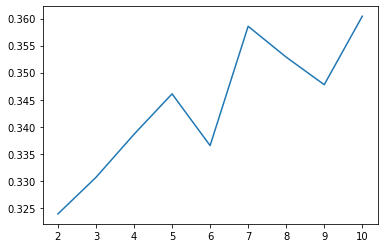

In [28]:
main('LDA')

LDA
Preprocessing raw texts ...
3086
Preprocessing raw texts. Done!
3075
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 

Fitting LDA ...
Fitting LDA Done!
Coherence: 0.3417016283726487
Silhouette Score: None
None
       idx topic
0        0  None
1        1  None
2        2  None
3        3  None
4        4  None
...    ...   ...
3070  3081  None
3071  3082  None
3072  3083  None
3073  3084  None
3074  3085  None

[3075 rows x 2 columns]


BERT
Preprocessing raw texts ...
3086
Preprocessing raw texts. Done!
3075
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 1

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.97k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/397 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Batches:   0%|          | 0/97 [00:00<?, ?it/s]

Getting vector representations for BERT. Done!
Clustering embeddings. Done!
Start get topic words
0
Done! and start get coherence
Get coherence done!
Coherence: 0.4570538756509386
Silhouette Score: 0.050503336
Calculating UMAP projection ...
Calculating UMAP projection. Done!


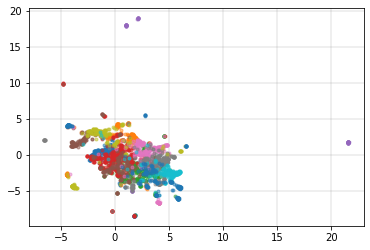

[5 2 0 ... 6 2 2]
3075
[5 2 0 ... 6 2 2]
       idx  topic
0        0      5
1        1      2
2        2      0
3        3      8
4        4      9
...    ...    ...
3070  3081      2
3071  3082      8
3072  3083      6
3073  3084      2
3074  3085      2

[3075 rows x 2 columns]


LDA_BERT
Preprocessing raw texts ...
3086
Preprocessing raw texts. Done!
3075
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 1

Getting vector representations for LDA ...
Getting vector representations for LDA. Done!
Getting vector representations for BERT ...


Batches:   0%|          | 0/97 [00:00<?, ?it/s]

Getting vector representations for BERT. Done!
Fitting Autoencoder ...
Fitting Autoencoder Done!
Clustering embeddings. Done!
Start get topic words
0
Done! and start get coherence
Get coherence done!
Coherence: 0.4489382543951396
Silhouette Score: 0.3081937
Calculating UMAP projection ...
Calculating UMAP projection. Done!


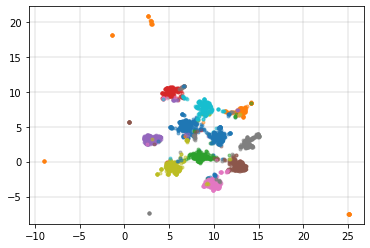

[ 4  2  6 ... 10  7  2]
3075
[ 4  2  6 ... 10  7  2]
       idx  topic
0        0      4
1        1      2
2        2      6
3        3      8
4        4      4
...    ...    ...
3070  3081      4
3071  3082      1
3072  3083     10
3073  3084      7
3074  3085      2

[3075 rows x 2 columns]




<Figure size 432x288 with 0 Axes>

In [31]:
choose = ['LDA', 'BERT', 'LDA_BERT']
for i in choose :
  main(i)
  print('\n')

BERT
Preprocessing raw texts ...
3086
Preprocessing raw texts. Done!
3075
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209,

Batches:   0%|          | 0/97 [00:00<?, ?it/s]

Getting vector representations for BERT. Done!
Clustering embeddings. Done!
Start get topic words
0
Done! and start get coherence
Get coherence done!
Coherence: 0.4602698929715883
Silhouette Score: 0.05231468
Calculating UMAP projection ...
Calculating UMAP projection. Done!


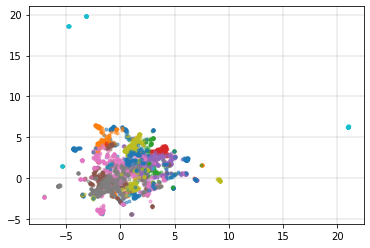

[6 4 5 ... 8 6 6]
3075
[6 4 5 ... 8 6 6]
       idx  topic
0        0      6
1        1      4
2        2      5
3        3      0
4        4      3
...    ...    ...
3070  3081      4
3071  3082      1
3072  3083      8
3073  3084      6
3074  3085      6

[3075 rows x 2 columns]


,idx,topic
0,0,6
1,1,4
2,2,5
3,3,0
4,4,3
...,...,...
3070,3081,4
3071,3082,1
3072,3083,8
3073,3084,6


<Figure size 432x288 with 0 Axes>

In [37]:
main("BERT")

LDA_BERT
Preprocessing raw texts ...
3086
Preprocessing raw texts. Done!
3075
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 

Getting vector representations for LDA ...
Getting vector representations for LDA. Done!
Getting vector representations for BERT ...


Batches:   0%|          | 0/97 [00:00<?, ?it/s]

Getting vector representations for BERT. Done!
Fitting Autoencoder ...
Fitting Autoencoder Done!
Clustering embeddings. Done!
Start get topic words
0
Done! and start get coherence
Get coherence done!
Coherence: 0.477410221849461
Silhouette Score: 0.2582312
Calculating UMAP projection ...
Calculating UMAP projection. Done!


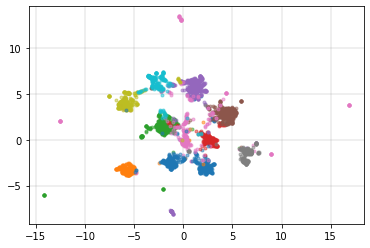

[8 3 3 ... 9 3 6]
3075
[8 3 3 ... 9 3 6]
       idx  topic
0        0      8
1        1      3
2        2      3
3        3      9
4        4      3
...    ...    ...
3070  3081      2
3071  3082      3
3072  3083      9
3073  3084      3
3074  3085      6

[3075 rows x 2 columns]


,text,index,topic
0,What is COVID-19 + COVID-19 is the infectious ...,0,8
1,What are the symptoms of COVID-19 + The most c...,1,3
2,How does COVID-19 spread + People can catch CO...,2,3
3,Can the virus that causes COVID-19 be transmit...,3,9
4,Can CoVID-19 be caught from a person who has n...,4,3
...,...,...,...
3070,"Coronavirus, COVID-19 has high affinity to t...",3081,2
3071,COVID These are HealthTap guidelines:https:/...,3082,3
3072,Covid-19 unlikely. The usual infections in y...,3083,9
3073,Symptoms vary. Some may have no symptoms at ...,3084,3


<Figure size 432x288 with 0 Axes>

In [38]:
label_df = main("LDA_BERT")
main_df['idx'] = main_df.index.values

In [63]:
main_df.drop(['text'], axis = 1, inplace = True)
main_df['idx'] = main_df.index.values
final = pd.merge(main_df, label_df, on = 'idx', how = 'inner')

,index,Question,Answer,idx,topic
0,0,What is COVID-19,COVID-19 is the infectious disease caused by t...,0,8
1,1,What are the symptoms of COVID-19,The most common symptoms of COVID-19 are fever...,1,3
2,2,How does COVID-19 spread,People can catch COVID-19 from others who have...,2,3
3,3,Can the virus that causes COVID-19 be transmit...,Studies to date suggest that the virus that ca...,3,9
4,4,Can CoVID-19 be caught from a person who has n...,The risk of catching COVID-19 from someone wit...,4,3
...,...,...,...,...,...
3070,3081,"Coronavirus, COVID-19 has high affinity to t...","If I get coronavirus, are there ways to avoid ...",3081,2
3071,3082,COVID These are HealthTap guidelines:https:/...,I was on a plane on March 8th have been home e...,3082,3
3072,3083,Covid-19 unlikely. The usual infections in y...,"My son has a fever, I am concerned due to the ...",3083,9
3073,3084,Symptoms vary. Some may have no symptoms at ...,Can coronavirus symptoms be mild for some peop...,3084,3


In [64]:
final.drop(['index'], axis = 1, inplace = True)
final.to_csv('Final_topicLabel.csv', index = None)

In [65]:
final

,Question,Answer,idx,topic
0,What is COVID-19,COVID-19 is the infectious disease caused by t...,0,8
1,What are the symptoms of COVID-19,The most common symptoms of COVID-19 are fever...,1,3
2,How does COVID-19 spread,People can catch COVID-19 from others who have...,2,3
3,Can the virus that causes COVID-19 be transmit...,Studies to date suggest that the virus that ca...,3,9
4,Can CoVID-19 be caught from a person who has n...,The risk of catching COVID-19 from someone wit...,4,3
...,...,...,...,...
3070,"Coronavirus, COVID-19 has high affinity to t...","If I get coronavirus, are there ways to avoid ...",3081,2
3071,COVID These are HealthTap guidelines:https:/...,I was on a plane on March 8th have been home e...,3082,3
3072,Covid-19 unlikely. The usual infections in y...,"My son has a fever, I am concerned due to the ...",3083,9
3073,Symptoms vary. Some may have no symptoms at ...,Can coronavirus symptoms be mild for some peop...,3084,3


# Sentiment Label 매기기

In [102]:
from IPython.display import clear_output
clear_output()

df = pd.read_csv("Final_topicLabel.csv", sep = ',')
df

,Question,Answer,idx,topic
0,What is COVID-19,COVID-19 is the infectious disease caused by t...,0,8
1,What are the symptoms of COVID-19,The most common symptoms of COVID-19 are fever...,1,3
2,How does COVID-19 spread,People can catch COVID-19 from others who have...,2,3
3,Can the virus that causes COVID-19 be transmit...,Studies to date suggest that the virus that ca...,3,9
4,Can CoVID-19 be caught from a person who has n...,The risk of catching COVID-19 from someone wit...,4,3
...,...,...,...,...
3070,"Coronavirus, COVID-19 has high affinity to t...","If I get coronavirus, are there ways to avoid ...",3081,2
3071,COVID These are HealthTap guidelines:https:/...,I was on a plane on March 8th have been home e...,3082,3
3072,Covid-19 unlikely. The usual infections in y...,"My son has a fever, I am concerned due to the ...",3083,9
3073,Symptoms vary. Some may have no symptoms at ...,Can coronavirus symptoms be mild for some peop...,3084,3


In [103]:
main_df = pd.DataFrame(df, columns = ['text', 'topic'])
main_df['text'] = df['Question'] + " + " + df["Answer"]
main_df['topic'] = df.topic.values
main_df['idx'] = main_df.index.values
main_df

,text,topic,idx
0,What is COVID-19 + COVID-19 is the infectious ...,8,0
1,What are the symptoms of COVID-19 + The most c...,3,1
2,How does COVID-19 spread + People can catch CO...,3,2
3,Can the virus that causes COVID-19 be transmit...,9,3
4,Can CoVID-19 be caught from a person who has n...,3,4
...,...,...,...
3070,"Coronavirus, COVID-19 has high affinity to t...",2,3070
3071,COVID These are HealthTap guidelines:https:/...,3,3071
3072,Covid-19 unlikely. The usual infections in y...,9,3072
3073,Symptoms vary. Some may have no symptoms at ...,3,3073


In [69]:
from tqdm import tqdm
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import pkg_resources

import datetime
import time
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

clear_output()

In [70]:
from collections import Counter
from sklearn.metrics import silhouette_score
!pip install symspellpy
!pip install language_detector
!pip install stop_words
import pkg_resources
from symspellpy import SymSpell, Verbosity
from language_detector import detect_language
from gensim.models.coherencemodel import CoherenceModel
from stop_words import get_stop_words
clear_output()

In [71]:
sym_spell = SymSpell(max_dictionary_edit_distance=3, prefix_length = 7)
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
if sym_spell.word_count:
  pass
else :
  sym_spell.load_dictionary(dictionary_path, term_index = 0, count_index = 1)

# some basic normalization
def f_base(s):
    """
    :param s: string to be processed
    :return: processed string: see comments in the source code for more info
    """
    # normalization 1: xxxThis is a --> xxx. This is a (missing delimiter)
    s = re.sub(r'([a-z])([A-Z])', r'\1\. \2', s)  # before lower case
    # normalization 2: lower case
    s = s.lower()
    # normalization 3: "&gt", "&lt"
    s = re.sub(r'&gt|&lt', ' ', s)
    # normalization 4: letter repetition (if more than 2)
    s = re.sub(r'([a-z])\1{2,}', r'\1', s)
    # normalization 5: non-word repetition (if more than 1)
    s = re.sub(r'([\W+])\1{1,}', r'\1', s)
    # normalization 6: string * as delimiter
    s = re.sub(r'\*|\W\*|\*\W', '. ', s)
    # normalization 7: stuff in parenthesis, assumed to be less informal
    s = re.sub(r'\(.*?\)', '. ', s)
    # normalization 8: xxx[?!]. -- > xxx.
    s = re.sub(r'\W+?\.', '.', s)
    # normalization 9: [.?!] --> [.?!] xxx
    s = re.sub(r'(\.|\?|!)(\w)', r'\1 \2', s)
    # normalization 10: ' ing ', noise text
    s = re.sub(r' ing ', ' ', s)
    # normalization 11: noise text
    s = re.sub(r'product received for free[.| ]', ' ', s)
    # normalization 12: phrase repetition
    s = re.sub(r'(.{2,}?)\1{1,}', r'\1', s)

    return s.strip()

def f_lan(s):
  return detect_language(s) in {'English'}

###############################
#### word level preprocess ####
###############################

# filtering out punctuations and numbers
def f_punct(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with punct and number filter out
    """
    return [word for word in w_list if word.isalpha()]


# selecting nouns
def f_noun(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with only nouns selected
    """
    return [word for (word, pos) in nltk.pos_tag(w_list) if pos[:2] == 'NN']


# typo correction
def f_typo(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with typo fixed by symspell. words with no match up will be dropped
    """
    w_list_fixed = []
    for word in w_list:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=3)
        if suggestions:
            w_list_fixed.append(suggestions[0].term)
        else:
            pass
            # do word segmentation, deprecated for inefficiency
            # w_seg = sym_spell.word_segmentation(phrase=word)
            # w_list_fixed.extend(w_seg.corrected_string.split())
    return w_list_fixed


# stemming if doing word-wise
p_stemmer = PorterStemmer()


def f_stem(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with stemming
    """
    return [p_stemmer.stem(word) for word in w_list]


# filtering out stop words
# create English stop words list

stop_words = (list(
    set(get_stop_words('en'))
    |set(get_stop_words('es'))
    |set(get_stop_words('de'))
    |set(get_stop_words('it'))
    |set(get_stop_words('ca'))
    #|set(get_stop_words('cy'))
    |set(get_stop_words('pt'))
    #|set(get_stop_words('tl'))
    |set(get_stop_words('pl'))
    #|set(get_stop_words('et'))
    |set(get_stop_words('da'))
    |set(get_stop_words('ru'))
    #|set(get_stop_words('so'))
    |set(get_stop_words('sv'))
    |set(get_stop_words('sk'))
    #|set(get_stop_words('cs'))
    |set(get_stop_words('nl'))
    #|set(get_stop_words('sl'))
    #|set(get_stop_words('no'))
    #|set(get_stop_words('zh-cn'))
))


def f_stopw(w_list):
    """
    filtering out stop words
    """
    return [word for word in w_list if word not in stop_words]


def preprocess_sent(rw):
    """
    Get sentence level preprocessed data from raw review texts
    :param rw: review to be processed
    :return: sentence level pre-processed review
    """
    s = f_base(rw)
    if not f_lan(s):
        return None
    return s


def preprocess_word(s):
    """
    Get word level preprocessed data from preprocessed sentences
    including: remove punctuation, select noun, fix typo, stem, stop_words
    :param s: sentence to be processed
    :return: word level pre-processed review
    """
    if not s:
        return None
    w_list = word_tokenize(s)
    w_list = f_punct(w_list)
    w_list = f_noun(w_list)
    w_list = f_typo(w_list)
    w_list = f_stem(w_list)
    w_list = f_stopw(w_list)

    return w_list

In [72]:
def preprocess(docs, samp_size=None):
    """
    Preprocess the data
    """
    if not samp_size:
        samp_size = 100

    print('Preprocessing raw texts ...')
    n_docs = len(docs)
    sentences = []  # sentence level preprocessed
    token_lists = []  # word level preprocessed
    idx_in = []  # index of sample selected

    # 임의 표본 추출하기(원래 사이즈, 표본 사이즈)
    samp = np.array(range(0, n_docs))
    #samp = np.random.choice(n_docs, samp_size)
    print(len(samp))
    print(samp)
    for i, idx in enumerate(samp):
        sentence = preprocess_sent(docs['text'].iloc[idx])
        token_list = preprocess_word(sentence)
        if token_list:
            idx_in.append(idx)
            sentences.append(sentence)
            token_lists.append(token_list)
        print('{} %'.format(str(np.round((i + 1) / len(samp) * 100, 2))), end='\r')
    print('Preprocessing raw texts. Done!')
    return sentences, token_lists, idx_in


In [74]:
# sentences : 원래 문장 있는 그대로
# token_lists : sentences를 token화한 것
# idx_in : idx 숫자 -> samp size때문에 바뀌는 거
question = pd.DataFrame(np.array(df['Question']), columns = ['text'])
print(question.head())
sentences_Q, token_lists_Q, idx_in_Q = preprocess(question, samp_size = len(df))

answer = pd.DataFrame(np.array(df['Answer']), columns = ['text'])
print(answer.head())
sentences_A, token_lists_A, idx_in_A = preprocess(answer, samp_size = len(df))

                                                text
0                                   What is COVID-19
1                  What are the symptoms of COVID-19
2                           How does COVID-19 spread
3  Can the virus that causes COVID-19 be transmit...
4  Can CoVID-19 be caught from a person who has n...
Preprocessing raw texts ...
3075
[   0    1    2 ... 3072 3073 3074]
Preprocessing raw texts. Done!
                                                text
0  COVID-19 is the infectious disease caused by t...
1  The most common symptoms of COVID-19 are fever...
2  People can catch COVID-19 from others who have...
3  Studies to date suggest that the virus that ca...
4  The risk of catching COVID-19 from someone wit...
Preprocessing raw texts ...
3075
[   0    1    2 ... 3072 3073 3074]
Preprocessing raw texts. Done!


In [75]:
token_lists_Q = np.array(token_lists_Q)
token_lists_Q

array([list(['symptom']), list(['viru', 'air']),
       list(['person', 'symptom']), ...,
       list(['infect', 'area', 'kwa', 'zulu', 'natal', 'caus', 'fever', 'someon', 'treat', 'month', 'short', 'breath', 'form', 'difficulti', 'doctor', 'asap', 'chat']),
       list(['symptom', 'symptom', 'life', 'chat']),
       list(['call', 'throat', 'pain', 'strep', 'throat', 'infect', 'cold', 'influenza', 'caus', 'allergi', 'irrit', 'person', 'doctor', 'sore', 'throat', 'recurr', 'wherea', 'cough', 'throat', 'pain', 'chat'])],
      dtype=object)

In [76]:
token_lists_A = np.array(token_lists_A)
token_lists_A

array([list(['diseas', 'viru', 'diseas', 'outbreak', 'china', 'decemb']),
       list(['symptom', 'tired', 'cough', 'patient', 'pain', 'congest', 'runni', 'throat', 'symptom', 'peopl', 'symptom']),
       list(['peopl', 'viru', 'diseas', 'person', 'person', 'droplet', 'nose', 'mouth', 'person', 'cough', 'droplet', 'object', 'surfac', 'person', 'peopl', 'object', 'surfac', 'eye', 'peopl', 'droplet', 'person', 'exhal', 'droplet']),
       ..., list(['fever']),
       list(['symptom', 'peopl', 'exampl', 'grade', 'fever', 'day', 'extrem', 'symptom', 'blown', 'cold', 'struggl']),
       list(['day', 'week', 'profess', 'year', 'chest', 'throat', 'headach', 'dizzi', 'time'])],
      dtype=object)

In [96]:
token_Q = pd.DataFrame(data = token_lists_Q, columns = ['token_Question'])
idx_Q = pd.DataFrame(data = idx_in_Q, columns = ['idx'])
Question = pd.concat([token_Q, idx_Q], axis = 1)

token_A = pd.DataFrame(data = token_lists_A, columns = ['token_Answer'])
idx_A = pd.DataFrame(data = idx_in_A, columns = ['idx'])
Answer = pd.concat([token_A, idx_A], axis = 1)

token = pd.merge(Question, Answer, on = 'idx', how = 'inner')
token.drop(['idx'], axis = 1, inplace = True)
token

,token_Question,token_Answer
0,[symptom],"[symptom, tired, cough, patient, pain, congest..."
1,"[viru, air]","[studi, date, suggest, viru, contact, droplet,..."
2,"[person, symptom]","[risk, someon, symptom]"
3,"[spread, diseas]","[hand, hand, rub, soap, water, feet, distanc, ..."
4,[mask],"[peopl, respiratori, symptom, cough, mask, use..."
...,...,...
2798,"[affin, lung, pneumonia, peopl, respiratori, s...","[way, ill, pneumonia]"
2799,"[covid, health, tap, guidelin, haft, inc, symp...","[plane, march, self, quarantin, headach, throa..."
2800,"[infect, area, kwa, zulu, natal, caus, fever, ...",[fever]
2801,"[symptom, symptom, life, chat]","[symptom, peopl, exampl, grade, fever, day, ex..."


In [99]:
sentences_Q = np.array(sentences_Q)
sentences_A = np.array(sentences_A)

s_Q = pd.DataFrame(data = sentences_Q, columns = ['sentence_Question'])
s_Question = pd.concat([s_Q, idx_Q], axis = 1)

s_A = pd.DataFrame(data = sentences_A, columns = ['sentence_Answer'])
s_Answer = pd.concat([s_A, idx_A], axis = 1)

s = pd.merge(s_Question, s_Answer, on = 'idx', how = 'inner')
#s.drop(['idx'], axis = 1, inplace = True)
s

,sentence_Question,idx,sentence_Answer
0,what are the symptoms of covid-19,1,the most common symptoms of covid-19 are fever...
1,can the virus that causes covid-19 be transmit...,3,studies to date suggest that the virus that ca...
2,can co. vid-19 be caught from a person who has...,4,the risk of catching covid-19 from someone wit...
3,what can i do to protect myself and prevent th...,5,regularly and thoroughly clean your hands with...
4,should i wear a mask to protect myself,6,"people with no respiratory symptoms, such as c..."
...,...,...,...
2798,"coronavirus, covid-19 has high affinity to the...",3070,"if i get coronavirus, are there ways to avoid ..."
2799,covid these are health. tap guidelines:https:/...,3071,i was on a plane on march 8th have been home e...
2800,covid-19 unlikely. the usual infections in you...,3072,"my son has a fever, i am concerned due to the ..."
2801,symptoms vary. some may have no symptoms at al...,3073,can coronavirus symptoms be mild for some peop...


In [104]:
result = pd.concat([s, token], axis = 1)
result = pd.merge(result, main_df, on = 'idx', how = 'inner')
result.dropna(axis = 0, inplace = True)
result

,sentence_Question,idx,sentence_Answer,token_Question,token_Answer,text,topic
0,what are the symptoms of covid-19,1,the most common symptoms of covid-19 are fever...,[symptom],"[symptom, tired, cough, patient, pain, congest...",What are the symptoms of COVID-19 + The most c...,3
1,can the virus that causes covid-19 be transmit...,3,studies to date suggest that the virus that ca...,"[viru, air]","[studi, date, suggest, viru, contact, droplet,...",Can the virus that causes COVID-19 be transmit...,9
2,can co. vid-19 be caught from a person who has...,4,the risk of catching covid-19 from someone wit...,"[person, symptom]","[risk, someon, symptom]",Can CoVID-19 be caught from a person who has n...,3
3,what can i do to protect myself and prevent th...,5,regularly and thoroughly clean your hands with...,"[spread, diseas]","[hand, hand, rub, soap, water, feet, distanc, ...",What can I do to protect myself and prevent th...,1
4,should i wear a mask to protect myself,6,"people with no respiratory symptoms, such as c...",[mask],"[peopl, respiratori, symptom, cough, mask, use...",Should I wear a mask to protect myself + Peopl...,3
...,...,...,...,...,...,...,...
2798,"coronavirus, covid-19 has high affinity to the...",3070,"if i get coronavirus, are there ways to avoid ...","[affin, lung, pneumonia, peopl, respiratori, s...","[way, ill, pneumonia]","Coronavirus, COVID-19 has high affinity to t...",2
2799,covid these are health. tap guidelines:https:/...,3071,i was on a plane on march 8th have been home e...,"[covid, health, tap, guidelin, haft, inc, symp...","[plane, march, self, quarantin, headach, throa...",COVID These are HealthTap guidelines:https:/...,3
2800,covid-19 unlikely. the usual infections in you...,3072,"my son has a fever, i am concerned due to the ...","[infect, area, kwa, zulu, natal, caus, fever, ...",[fever],Covid-19 unlikely. The usual infections in y...,9
2801,symptoms vary. some may have no symptoms at al...,3073,can coronavirus symptoms be mild for some peop...,"[symptom, symptom, life, chat]","[symptom, peopl, exampl, grade, fever, day, ex...",Symptoms vary. Some may have no symptoms at ...,3


* Sentiment score 매기기

In [105]:
sent = SentimentIntensityAnalyzer()
polarity = [round(sent.polarity_scores(i)['compound'], 2) for i in result['text']]
result['sentiment_score'] = polarity
result

,sentence_Question,idx,sentence_Answer,token_Question,token_Answer,text,topic,sentiment_score
0,what are the symptoms of covid-19,1,the most common symptoms of covid-19 are fever...,[symptom],"[symptom, tired, cough, patient, pain, congest...",What are the symptoms of COVID-19 + The most c...,3,-0.64
1,can the virus that causes covid-19 be transmit...,3,studies to date suggest that the virus that ca...,"[viru, air]","[studi, date, suggest, viru, contact, droplet,...",Can the virus that causes COVID-19 be transmit...,9,0.00
2,can co. vid-19 be caught from a person who has...,4,the risk of catching covid-19 from someone wit...,"[person, symptom]","[risk, someon, symptom]",Can CoVID-19 be caught from a person who has n...,3,-0.67
3,what can i do to protect myself and prevent th...,5,regularly and thoroughly clean your hands with...,"[spread, diseas]","[hand, hand, rub, soap, water, feet, distanc, ...",What can I do to protect myself and prevent th...,1,0.84
4,should i wear a mask to protect myself,6,"people with no respiratory symptoms, such as c...",[mask],"[peopl, respiratori, symptom, cough, mask, use...",Should I wear a mask to protect myself + Peopl...,3,0.67
...,...,...,...,...,...,...,...,...
2798,"coronavirus, covid-19 has high affinity to the...",3070,"if i get coronavirus, are there ways to avoid ...","[affin, lung, pneumonia, peopl, respiratori, s...","[way, ill, pneumonia]","Coronavirus, COVID-19 has high affinity to t...",2,0.29
2799,covid these are health. tap guidelines:https:/...,3071,i was on a plane on march 8th have been home e...,"[covid, health, tap, guidelin, haft, inc, symp...","[plane, march, self, quarantin, headach, throa...",COVID These are HealthTap guidelines:https:/...,3,0.64
2800,covid-19 unlikely. the usual infections in you...,3072,"my son has a fever, i am concerned due to the ...","[infect, area, kwa, zulu, natal, caus, fever, ...",[fever],Covid-19 unlikely. The usual infections in y...,9,-0.29
2801,symptoms vary. some may have no symptoms at al...,3073,can coronavirus symptoms be mild for some peop...,"[symptom, symptom, life, chat]","[symptom, peopl, exampl, grade, fever, day, ex...",Symptoms vary. Some may have no symptoms at ...,3,-0.92


In [106]:
result['sentiment'] = 0
result.loc[result['sentiment_score'] < 0, 'sentiment'] = 0
result.loc[result['sentiment_score'] == 0, 'sentiment'] = 1
result.loc[result['sentiment_score'] > 0, 'sentiment'] = 2
result

,sentence_Question,idx,sentence_Answer,token_Question,token_Answer,text,topic,sentiment_score,sentiment
0,what are the symptoms of covid-19,1,the most common symptoms of covid-19 are fever...,[symptom],"[symptom, tired, cough, patient, pain, congest...",What are the symptoms of COVID-19 + The most c...,3,-0.64,0
1,can the virus that causes covid-19 be transmit...,3,studies to date suggest that the virus that ca...,"[viru, air]","[studi, date, suggest, viru, contact, droplet,...",Can the virus that causes COVID-19 be transmit...,9,0.00,1
2,can co. vid-19 be caught from a person who has...,4,the risk of catching covid-19 from someone wit...,"[person, symptom]","[risk, someon, symptom]",Can CoVID-19 be caught from a person who has n...,3,-0.67,0
3,what can i do to protect myself and prevent th...,5,regularly and thoroughly clean your hands with...,"[spread, diseas]","[hand, hand, rub, soap, water, feet, distanc, ...",What can I do to protect myself and prevent th...,1,0.84,2
4,should i wear a mask to protect myself,6,"people with no respiratory symptoms, such as c...",[mask],"[peopl, respiratori, symptom, cough, mask, use...",Should I wear a mask to protect myself + Peopl...,3,0.67,2
...,...,...,...,...,...,...,...,...,...
2798,"coronavirus, covid-19 has high affinity to the...",3070,"if i get coronavirus, are there ways to avoid ...","[affin, lung, pneumonia, peopl, respiratori, s...","[way, ill, pneumonia]","Coronavirus, COVID-19 has high affinity to t...",2,0.29,2
2799,covid these are health. tap guidelines:https:/...,3071,i was on a plane on march 8th have been home e...,"[covid, health, tap, guidelin, haft, inc, symp...","[plane, march, self, quarantin, headach, throa...",COVID These are HealthTap guidelines:https:/...,3,0.64,2
2800,covid-19 unlikely. the usual infections in you...,3072,"my son has a fever, i am concerned due to the ...","[infect, area, kwa, zulu, natal, caus, fever, ...",[fever],Covid-19 unlikely. The usual infections in y...,9,-0.29,0
2801,symptoms vary. some may have no symptoms at al...,3073,can coronavirus symptoms be mild for some peop...,"[symptom, symptom, life, chat]","[symptom, peopl, exampl, grade, fever, day, ex...",Symptoms vary. Some may have no symptoms at ...,3,-0.92,0


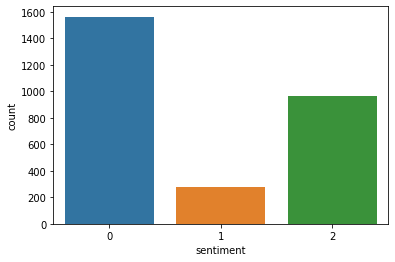

In [107]:
import seaborn as sns
sns.countplot(x = 'sentiment', data = result)
plt.xticks = ([0, 1, 2], ['negative', 'neutral', 'positive'])
plt.show()

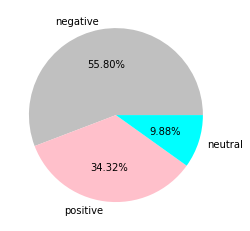

In [108]:
colors = pd.Series(['silver', 'pink', 'cyan'])
plt.pie(result['sentiment'].value_counts(), labels = ['negative', 'positive', 'neutral'],
        colors = colors, autopct = '%.2f%%') # 소수점 두자리까지 표시
plt.show()

In [109]:
df = result[['sentence_Question', 'sentence_Answer', 'topic', 'sentiment']]
df

,sentence_Question,sentence_Answer,topic,sentiment
0,what are the symptoms of covid-19,the most common symptoms of covid-19 are fever...,3,0
1,can the virus that causes covid-19 be transmit...,studies to date suggest that the virus that ca...,9,1
2,can co. vid-19 be caught from a person who has...,the risk of catching covid-19 from someone wit...,3,0
3,what can i do to protect myself and prevent th...,regularly and thoroughly clean your hands with...,1,2
4,should i wear a mask to protect myself,"people with no respiratory symptoms, such as c...",3,2
...,...,...,...,...
2798,"coronavirus, covid-19 has high affinity to the...","if i get coronavirus, are there ways to avoid ...",2,2
2799,covid these are health. tap guidelines:https:/...,i was on a plane on march 8th have been home e...,3,2
2800,covid-19 unlikely. the usual infections in you...,"my son has a fever, i am concerned due to the ...",9,0
2801,symptoms vary. some may have no symptoms at al...,can coronavirus symptoms be mild for some peop...,3,0


In [110]:
df.to_csv('/content/drive/MyDrive/covid analysis/Final_T&S_label.csv')